In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [9]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

device

device(type='cuda')

In [10]:
#data_path = "drive/My Drive/Simple_Chest_XRay/"
data_path = "ck_dataset/"
#data_path = "drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 1
batch_size = 96
num_epochs = 40

In [11]:
# Set random seed for reproducibility
# torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**DATA PREPROCESSING**


In [12]:
%run "utils.ipynb"
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio, batch_size)

 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [13]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [14]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
losses, accuracies, true, pred, v_accuracies, v_losses = [], [], [], [], [], []

Using cache found in C:\Users\Saketh/.cache\torch\hub\pytorch_vision_v0.9.0


In [15]:
for a in train_loader:
    print (a)

[tensor([[[[-1.8782, -1.8782, -1.8782,  ..., -2.1008, -2.1008, -2.1008],
          [-1.8782, -1.8782, -1.8782,  ..., -2.1008, -2.1008, -2.1008],
          [-1.8610, -1.8610, -1.8610,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [-1.4500, -1.4500, -1.4500,  ..., -1.5528, -1.5528, -1.5528],
          [-1.4500, -1.4500, -1.4500,  ..., -1.5528, -1.5528, -1.5528],
          [-1.4500, -1.4500, -1.4500,  ..., -1.5528, -1.5528, -1.5528]],

         [[-1.7906, -1.7906, -1.7906,  ..., -2.0182, -2.0182, -2.0182],
          [-1.7906, -1.7906, -1.7906,  ..., -2.0182, -2.0182, -2.0182],
          [-1.7731, -1.7731, -1.7731,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-1.3529, -1.3529, -1.3529,  ..., -1.4580, -1.4580, -1.4580],
          [-1.3529, -1.3529, -1.3529,  ..., -1.4580, -1.4580, -1.4580],
          [-1.3529, -1.3529, -1.3529,  ..., -1.4580, -1.4580, -1.4580]],

         [[-1.5604, -1.5604, -1.5604,  ..., -1.7870, -1.7870, -1.7870],
          [-1.5604, -1.5604, 

[tensor([[[[-1.4329, -1.4329, -1.4329,  ..., -0.5424, -0.5082, -0.5082],
          [-1.4329, -1.4329, -1.4329,  ..., -0.5424, -0.5082, -0.5082],
          [-1.4329, -1.4329, -1.4329,  ..., -0.5596, -0.5253, -0.5253],
          ...,
          [-1.9638, -1.9638, -1.9467,  ..., -1.7412, -1.7412, -1.7412],
          [-1.9638, -1.9638, -1.9467,  ..., -1.7412, -1.7412, -1.7412],
          [-1.9638, -1.9638, -1.9467,  ..., -1.7412, -1.7412, -1.7412]],

         [[-1.3354, -1.3354, -1.3354,  ..., -0.4251, -0.3901, -0.3901],
          [-1.3354, -1.3354, -1.3354,  ..., -0.4251, -0.3901, -0.3901],
          [-1.3354, -1.3354, -1.3354,  ..., -0.4426, -0.4076, -0.4076],
          ...,
          [-1.8782, -1.8782, -1.8606,  ..., -1.6506, -1.6506, -1.6506],
          [-1.8782, -1.8782, -1.8606,  ..., -1.6506, -1.6506, -1.6506],
          [-1.8782, -1.8782, -1.8606,  ..., -1.6506, -1.6506, -1.6506]],

         [[-1.1073, -1.1073, -1.1073,  ..., -0.2010, -0.1661, -0.1661],
          [-1.1073, -1.1073, 

In [16]:
# Train model on training set
for epoch in range(num_epochs):
  train_loss, train_accuracy, start_time = 0.0, 0.0, time.time()

  with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
      for inputs, labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_accuracy += torch.sum(preds == labels.data)
          pred.extend(preds.cpu().numpy())
          true.extend(labels.cpu().numpy())
          
          pbar.set_postfix({'loss': loss.item()})
          pbar.update()

  train_loss /= len(train_indices)
  train_accuracy /= len(train_indices)
  _recall = recall_score(true, pred, average='macro')
  _precision = precision_score(true, pred, average='macro')
  _fscore = f1_score(true, pred, average='macro')

  print('Epoch: {} | Accuracy: {:.4f} | Loss: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F-Score: {:.4f} | Time: {:.4f}s'.format(epoch+1, train_accuracy, train_loss, _recall, _precision, _fscore, time.time() - start_time))
  val_accuracy, val_loss = evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, "ResNet18")
  v_accuracies.append(val_accuracy)
  v_losses.append(val_loss)
  losses.append(train_loss)
  accuracies.append(train_accuracy.item())

save_metrics(losses, accuracies, "ResNet18")

Epoch 1/40: 100%|██████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.22s/batch, loss=1.43]


Epoch: 1 | Accuracy: 0.3353 | Loss: 1.7439 | Recall: 0.3060 | Precision: 0.3508 | F-Score: 0.2343 | Time: 17.8173s
VALIDATION: Accuracy: 0.1212 | Loss: 1.9773 | Recall: 0.2013 | Precision: 0.1945 | F-score: 0.0725



Epoch 2/40: 100%|███████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.33s/batch, loss=1.8]


Epoch: 2 | Accuracy: 0.2959 | Loss: 1.8019 | Recall: 0.2655 | Precision: 0.2245 | F-Score: 0.2227 | Time: 10.6858s
VALIDATION: Accuracy: 0.4747 | Loss: 1.6298 | Recall: 0.3290 | Precision: 0.2709 | F-score: 0.2918



Epoch 3/40: 100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/batch, loss=1.32]


Epoch: 3 | Accuracy: 0.4286 | Loss: 1.5663 | Recall: 0.2725 | Precision: 0.2430 | F-Score: 0.2416 | Time: 10.2230s
VALIDATION: Accuracy: 0.3131 | Loss: 1.6475 | Recall: 0.2208 | Precision: 0.1634 | F-score: 0.1497



Epoch 4/40: 100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.34s/batch, loss=1.28]


Epoch: 4 | Accuracy: 0.4694 | Loss: 1.3818 | Recall: 0.2928 | Precision: 0.2561 | F-Score: 0.2622 | Time: 10.7207s
VALIDATION: Accuracy: 0.4545 | Loss: 1.5053 | Recall: 0.3185 | Precision: 0.3130 | F-score: 0.2812



Epoch 5/40: 100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.33s/batch, loss=1.07]


Epoch: 5 | Accuracy: 0.5204 | Loss: 1.2385 | Recall: 0.3123 | Precision: 0.3040 | F-Score: 0.2858 | Time: 10.6499s
VALIDATION: Accuracy: 0.5859 | Loss: 1.2406 | Recall: 0.5010 | Precision: 0.4299 | F-score: 0.4528



Epoch 6/40: 100%|█████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.35s/batch, loss=0.929]


Epoch: 6 | Accuracy: 0.5933 | Loss: 1.0586 | Recall: 0.3433 | Precision: 0.3380 | F-Score: 0.3157 | Time: 10.8429s
VALIDATION: Accuracy: 0.5556 | Loss: 1.0694 | Recall: 0.4280 | Precision: 0.4289 | F-score: 0.3934



Epoch 7/40: 100%|█████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.35s/batch, loss=0.693]


Epoch: 7 | Accuracy: 0.5787 | Loss: 0.9880 | Recall: 0.3627 | Precision: 0.3574 | F-Score: 0.3391 | Time: 10.8362s
VALIDATION: Accuracy: 0.4747 | Loss: 1.2420 | Recall: 0.4679 | Precision: 0.4404 | F-score: 0.3449



Epoch 8/40: 100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.50s/batch, loss=1.11]


Epoch: 8 | Accuracy: 0.6589 | Loss: 0.8711 | Recall: 0.3864 | Precision: 0.3898 | F-Score: 0.3651 | Time: 12.0657s
VALIDATION: Accuracy: 0.6465 | Loss: 0.9763 | Recall: 0.6138 | Precision: 0.5332 | F-score: 0.5318



Epoch 9/40: 100%|█████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.45s/batch, loss=0.488]


Epoch: 9 | Accuracy: 0.7099 | Loss: 0.7673 | Recall: 0.4116 | Precision: 0.4276 | F-Score: 0.3949 | Time: 11.6182s
VALIDATION: Accuracy: 0.6465 | Loss: 0.9834 | Recall: 0.5958 | Precision: 0.5622 | F-score: 0.5483



Epoch 10/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.31s/batch, loss=0.685]


Epoch: 10 | Accuracy: 0.7245 | Loss: 0.7229 | Recall: 0.4334 | Precision: 0.4478 | F-Score: 0.4196 | Time: 10.4886s
VALIDATION: Accuracy: 0.7475 | Loss: 0.6677 | Recall: 0.6793 | Precision: 0.6261 | F-score: 0.6232



Epoch 11/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.36s/batch, loss=0.558]


Epoch: 11 | Accuracy: 0.7930 | Loss: 0.5560 | Recall: 0.4580 | Precision: 0.4724 | F-Score: 0.4471 | Time: 10.9347s
VALIDATION: Accuracy: 0.7879 | Loss: 0.6743 | Recall: 0.7334 | Precision: 0.7629 | F-score: 0.6706



Epoch 12/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.31s/batch, loss=0.388]


Epoch: 12 | Accuracy: 0.7945 | Loss: 0.5185 | Recall: 0.4775 | Precision: 0.4978 | F-Score: 0.4693 | Time: 10.5158s
VALIDATION: Accuracy: 0.6768 | Loss: 0.9042 | Recall: 0.6055 | Precision: 0.6002 | F-score: 0.5566



Epoch 13/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/batch, loss=0.126]


Epoch: 13 | Accuracy: 0.8163 | Loss: 0.4870 | Recall: 0.4970 | Precision: 0.5181 | F-Score: 0.4915 | Time: 10.2618s
VALIDATION: Accuracy: 0.7980 | Loss: 0.6073 | Recall: 0.7454 | Precision: 0.7329 | F-score: 0.7022



Epoch 14/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.32s/batch, loss=0.288]


Epoch: 14 | Accuracy: 0.8761 | Loss: 0.3664 | Recall: 0.5200 | Precision: 0.5467 | F-Score: 0.5170 | Time: 10.6351s
VALIDATION: Accuracy: 0.7475 | Loss: 0.6306 | Recall: 0.5837 | Precision: 0.6718 | F-score: 0.5736



Epoch 15/40: 100%|█████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/batch, loss=0.23]


Epoch: 15 | Accuracy: 0.8790 | Loss: 0.3285 | Recall: 0.5387 | Precision: 0.5676 | F-Score: 0.5382 | Time: 10.3350s
VALIDATION: Accuracy: 0.7879 | Loss: 0.5724 | Recall: 0.6898 | Precision: 0.7890 | F-score: 0.6866



Epoch 16/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.29s/batch, loss=0.427]


Epoch: 16 | Accuracy: 0.8411 | Loss: 0.4250 | Recall: 0.5532 | Precision: 0.5808 | F-Score: 0.5542 | Time: 10.4072s
VALIDATION: Accuracy: 0.7071 | Loss: 0.7635 | Recall: 0.6558 | Precision: 0.7121 | F-score: 0.5951



Epoch 17/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.23s/batch, loss=0.316]


Epoch: 17 | Accuracy: 0.8528 | Loss: 0.3931 | Recall: 0.5689 | Precision: 0.5977 | F-Score: 0.5714 | Time: 9.8594s
VALIDATION: Accuracy: 0.8687 | Loss: 0.4382 | Recall: 0.8013 | Precision: 0.8448 | F-score: 0.8125



Epoch 18/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.37s/batch, loss=0.265]


Epoch: 18 | Accuracy: 0.9082 | Loss: 0.2617 | Recall: 0.5846 | Precision: 0.6152 | F-Score: 0.5880 | Time: 11.0298s
VALIDATION: Accuracy: 0.8586 | Loss: 0.4969 | Recall: 0.7582 | Precision: 0.7887 | F-score: 0.7540



Epoch 19/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.41s/batch, loss=0.271]


Epoch: 19 | Accuracy: 0.9052 | Loss: 0.2664 | Recall: 0.5985 | Precision: 0.6295 | F-Score: 0.6028 | Time: 11.3616s
VALIDATION: Accuracy: 0.8788 | Loss: 0.3754 | Recall: 0.8278 | Precision: 0.8474 | F-score: 0.7812



Epoch 20/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.23s/batch, loss=0.682]


Epoch: 20 | Accuracy: 0.9227 | Loss: 0.2167 | Recall: 0.6131 | Precision: 0.6449 | F-Score: 0.6186 | Time: 9.9019s
VALIDATION: Accuracy: 0.6566 | Loss: 1.2448 | Recall: 0.6260 | Precision: 0.7976 | F-score: 0.6074



Epoch 21/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.24s/batch, loss=0.424]


Epoch: 21 | Accuracy: 0.8105 | Loss: 0.5622 | Recall: 0.6191 | Precision: 0.6495 | F-Score: 0.6237 | Time: 9.9773s
VALIDATION: Accuracy: 0.7778 | Loss: 0.5425 | Recall: 0.5875 | Precision: 0.6667 | F-score: 0.5671



Epoch 22/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.29s/batch, loss=0.0873]


Epoch: 22 | Accuracy: 0.8848 | Loss: 0.3519 | Recall: 0.6283 | Precision: 0.6590 | F-Score: 0.6344 | Time: 10.3665s
VALIDATION: Accuracy: 0.9192 | Loss: 0.3445 | Recall: 0.8908 | Precision: 0.8900 | F-score: 0.8712



Epoch 23/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.31s/batch, loss=0.225]


Epoch: 23 | Accuracy: 0.9344 | Loss: 0.1878 | Recall: 0.6400 | Precision: 0.6712 | F-Score: 0.6464 | Time: 10.5309s
VALIDATION: Accuracy: 0.9394 | Loss: 0.3125 | Recall: 0.8740 | Precision: 0.8897 | F-score: 0.8795



Epoch 24/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.41s/batch, loss=0.191]


Epoch: 24 | Accuracy: 0.9606 | Loss: 0.1449 | Recall: 0.6526 | Precision: 0.6837 | F-Score: 0.6598 | Time: 11.3994s
VALIDATION: Accuracy: 0.9091 | Loss: 0.2763 | Recall: 0.8099 | Precision: 0.8289 | F-score: 0.8160



Epoch 25/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.20s/batch, loss=0.0944]


Epoch: 25 | Accuracy: 0.9752 | Loss: 0.1034 | Recall: 0.6647 | Precision: 0.6963 | F-Score: 0.6724 | Time: 9.6824s
VALIDATION: Accuracy: 0.8687 | Loss: 0.3654 | Recall: 0.7569 | Precision: 0.7742 | F-score: 0.7597



Epoch 26/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.32s/batch, loss=0.0399]


Epoch: 26 | Accuracy: 0.9679 | Loss: 0.0942 | Recall: 0.6755 | Precision: 0.7072 | F-Score: 0.6838 | Time: 10.6437s
VALIDATION: Accuracy: 0.8889 | Loss: 0.2773 | Recall: 0.8233 | Precision: 0.8073 | F-score: 0.8122



Epoch 27/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.33s/batch, loss=0.0625]


Epoch: 27 | Accuracy: 0.9796 | Loss: 0.0695 | Recall: 0.6864 | Precision: 0.7180 | F-Score: 0.6950 | Time: 10.7241s
VALIDATION: Accuracy: 0.9091 | Loss: 0.2397 | Recall: 0.8016 | Precision: 0.8465 | F-score: 0.8187



Epoch 28/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/batch, loss=0.0961]


Epoch: 28 | Accuracy: 0.9869 | Loss: 0.0498 | Recall: 0.6968 | Precision: 0.7284 | F-Score: 0.7057 | Time: 10.3465s
VALIDATION: Accuracy: 0.9293 | Loss: 0.1915 | Recall: 0.9038 | Precision: 0.8855 | F-score: 0.8914



Epoch 29/40: 100%|█████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.22s/batch, loss=0.13]


Epoch: 29 | Accuracy: 0.9781 | Loss: 0.0677 | Recall: 0.7059 | Precision: 0.7372 | F-Score: 0.7152 | Time: 9.8229s
VALIDATION: Accuracy: 0.9091 | Loss: 0.2935 | Recall: 0.8308 | Precision: 0.8509 | F-score: 0.8289



Epoch 30/40: 100%|████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.26s/batch, loss=0.109]


Epoch: 30 | Accuracy: 0.9723 | Loss: 0.0699 | Recall: 0.7138 | Precision: 0.7448 | F-Score: 0.7235 | Time: 10.1770s
VALIDATION: Accuracy: 0.8687 | Loss: 0.4219 | Recall: 0.8149 | Precision: 0.8345 | F-score: 0.7747



Epoch 31/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/batch, loss=0.0287]


Epoch: 31 | Accuracy: 0.9665 | Loss: 0.0928 | Recall: 0.7212 | Precision: 0.7520 | F-Score: 0.7310 | Time: 9.1474s
VALIDATION: Accuracy: 0.9091 | Loss: 0.2653 | Recall: 0.8562 | Precision: 0.8651 | F-score: 0.8342



Epoch 32/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.20s/batch, loss=0.0329]


Epoch: 32 | Accuracy: 0.9752 | Loss: 0.0746 | Recall: 0.7288 | Precision: 0.7590 | F-Score: 0.7386 | Time: 9.7250s
VALIDATION: Accuracy: 0.8788 | Loss: 0.3510 | Recall: 0.7776 | Precision: 0.7962 | F-score: 0.7834



Epoch 33/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.21s/batch, loss=0.0242]


Epoch: 33 | Accuracy: 0.9840 | Loss: 0.0639 | Recall: 0.7362 | Precision: 0.7661 | F-Score: 0.7461 | Time: 9.7618s
VALIDATION: Accuracy: 0.9293 | Loss: 0.2575 | Recall: 0.8665 | Precision: 0.8840 | F-score: 0.8726



Epoch 34/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.22s/batch, loss=0.0462]


Epoch: 34 | Accuracy: 0.9913 | Loss: 0.0395 | Recall: 0.7437 | Precision: 0.7731 | F-Score: 0.7536 | Time: 9.8996s
VALIDATION: Accuracy: 0.9394 | Loss: 0.2700 | Recall: 0.8373 | Precision: 0.9608 | F-score: 0.8696



Epoch 35/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.21s/batch, loss=0.0124]


Epoch: 35 | Accuracy: 1.0000 | Loss: 0.0194 | Recall: 0.7510 | Precision: 0.7801 | F-Score: 0.7609 | Time: 9.8533s
VALIDATION: Accuracy: 0.9596 | Loss: 0.2453 | Recall: 0.9395 | Precision: 0.9566 | F-score: 0.9469



Epoch 36/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.24s/batch, loss=0.0272]


Epoch: 36 | Accuracy: 0.9956 | Loss: 0.0178 | Recall: 0.7577 | Precision: 0.7863 | F-Score: 0.7677 | Time: 10.0250s
VALIDATION: Accuracy: 0.9596 | Loss: 0.1709 | Recall: 0.9395 | Precision: 0.9566 | F-score: 0.9469



Epoch 37/40: 100%|██████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.22s/batch, loss=0.00188]


Epoch: 37 | Accuracy: 0.9985 | Loss: 0.0112 | Recall: 0.7642 | Precision: 0.7924 | F-Score: 0.7741 | Time: 9.8685s
VALIDATION: Accuracy: 0.9697 | Loss: 0.2218 | Recall: 0.9484 | Precision: 0.9779 | F-score: 0.9596



Epoch 38/40: 100%|███████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.18s/batch, loss=0.0088]


Epoch: 38 | Accuracy: 0.9985 | Loss: 0.0066 | Recall: 0.7704 | Precision: 0.7981 | F-Score: 0.7803 | Time: 9.5592s
VALIDATION: Accuracy: 0.9596 | Loss: 0.2466 | Recall: 0.9008 | Precision: 0.9717 | F-score: 0.9279



Epoch 39/40: 100%|██████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/batch, loss=0.00489]


Epoch: 39 | Accuracy: 0.9985 | Loss: 0.0087 | Recall: 0.7762 | Precision: 0.8036 | F-Score: 0.7861 | Time: 8.5309s
VALIDATION: Accuracy: 0.9697 | Loss: 0.1983 | Recall: 0.9484 | Precision: 0.9779 | F-score: 0.9596



Epoch 40/40: 100%|█████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/batch, loss=0.000484]


Epoch: 40 | Accuracy: 1.0000 | Loss: 0.0044 | Recall: 0.7818 | Precision: 0.8087 | F-Score: 0.7916 | Time: 8.1549s
VALIDATION: Accuracy: 0.9697 | Loss: 0.2260 | Recall: 0.9484 | Precision: 0.9779 | F-score: 0.9596



**SAVE MODEL PARAMETERS**

In [17]:
torch.save(model.state_dict(), "{}resnet18.pth".format(data_path))

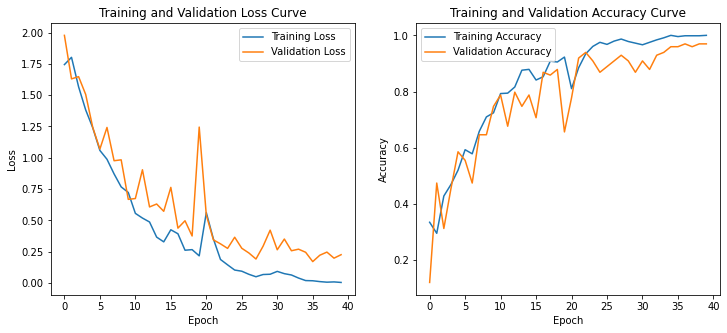

In [18]:
#Plotting the Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(losses, label = "Training Loss")
ax1.plot(v_losses, label = "Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curve')
ax1.legend()

ax2.plot(accuracies, label = "Training Accuracy")
ax2.plot(v_accuracies, label = "Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curve')
ax2.legend()

plt.show()

**EVALUATE MODEL ON TEST SET**

TEST: Accuracy: 0.9847 | Loss: 0.0595 | Recall: 0.9753 | Precision: 0.9864 | F-score: 0.9800



<Figure size 576x576 with 0 Axes>

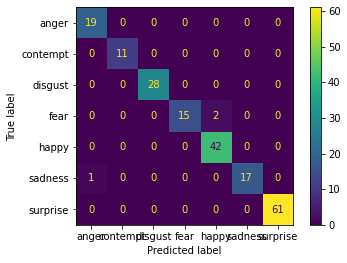

In [20]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "ResNet18")

In [ ]:
#Obtain the TSNE Plot for the data
features = []
labels = []
for images, targets in train_loader:
    with torch.no_grad():
        output = model(images)
        features.append(output.cpu().numpy())
        labels.append(targets.numpy())

features = np.vstack(features)
labels = np.concatenate(labels)

# Perform t-SNE on the feature vectors
tsne = TSNE(n_components=2, perplexity = 20, learning_rate = 600, n_iter = 900)
tsne_features = tsne.fit_transform(features)

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', len(dataset.classes)))
plt.legend()
plt.title('t-SNE Plot')
plt.show()

RuntimeError: ignored

In [ ]:
# Get the class labels and the number of classes
class_labels = dataset.classes
num_classes = len(class_labels)

# Get the number of images per class
num_images_per_class = []
for i in range(num_classes):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    num_images_per_class.append(len(class_indices))

# Compute the mean and variance of the images per class
mean_num_images = np.mean(num_images_per_class)
var_num_images = np.var(num_images_per_class)

# Plot the within-class variance
fig, ax = plt.subplots()
ax.bar(class_labels, num_images_per_class)
ax.axhline(y=mean_num_images, linestyle='--', color='r', label='Mean')
ax.axhspan(mean_num_images - np.sqrt(var_num_images), mean_num_images + np.sqrt(var_num_images),
           alpha=0.2, color='y', label='Variance')
ax.legend()
plt.xticks(rotation = 0)
plt.ylabel('Number of Images')
plt.xlabel('Class Labels')
plt.title('Within-Class Variance Plot')
plt.show()

In [ ]:
def within_class_variance(dataset, model):
    # Set the model to evaluation mode
    model.load_state_dict(model['model_state_dict'])
    model.eval()
    # Get the feature vectors and labels for the dataset
    features = []
    labels = []
    for images, targets in train_loader:
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          output = model(images)
          features.append(output.cpu().numpy()[0])
          labels.append(targets.cpu().numpy()[0])
    features = np.array(features)
    labels = np.array(labels)
    
    # Calculate the within-class variance for each class
    class_variances = []
    for c in np.unique(labels):
        class_features = features[labels == c]
        class_mean = np.mean(class_features, axis=0)
        class_variance = np.mean(np.sum((class_features - class_mean)**2, axis=1))
        class_variances.append(class_variance)
    
    return class_variances

# Define the dataset and model
# Calculate the within-class variance
class_variances = within_class_variance(dataset, model)

# Plot the within-class variances for each class
plt.bar(np.arange(len(class_variances)), class_variances)
plt.xticks(np.arange(len(class_variances)), dataset.classes, rotation='vertical')
plt.ylabel('Within-class variance')
plt.show()